In [1]:
#Prepare libraries
import tensorflow as tf
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time
import datetime
import data_helpers
from text_cnn import TextCNN
from tensorflow.contrib import learn

In [2]:
# Parameters

# Data loading params
tf.flags.DEFINE_float("dev_sample_percentage", .2, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("labeled_data_dir", "./labeled-data/", "Data directory for labeled data.")
tf.flags.DEFINE_string("extra_data_dir", "./extra-data/", "Data directory for extra data.")
# Model Hyperparameters
tf.flags.DEFINE_boolean("train_vec", False, "Train vector using our data")
tf.flags.DEFINE_boolean("trained_embedding", True, "Allow trained embedding or random embedding")
tf.flags.DEFINE_string("embedding_dir", "./embedding/", "Data directory for trained embedding.")
tf.flags.DEFINE_integer("embedding_dim", 300, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 64, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 32, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 100, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:-------------------------------------------------------")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")


Parameters:-------------------------------------------------------
ALLOW_SOFT_PLACEMENT=True
BATCH_SIZE=32
CHECKPOINT_EVERY=100
DEV_SAMPLE_PERCENTAGE=0.2
DROPOUT_KEEP_PROB=0.5
EMBEDDING_DIM=300
EMBEDDING_DIR=./embedding/
EVALUATE_EVERY=100
EXTRA_DATA_DIR=./extra-data/
FILTER_SIZES=3,4,5
L2_REG_LAMBDA=0.0
LABELED_DATA_DIR=./labeled-data/
LOG_DEVICE_PLACEMENT=False
NUM_CHECKPOINTS=5
NUM_EPOCHS=100
NUM_FILTERS=64
TRAIN_VEC=False
TRAINED_EMBEDDING=True



In [8]:
#Continous to discrete data
import pandas as pd
df = pd.read_csv('train_data.csv')
bins = [0, 3, 3.5, 4, 5]
category = pd.cut(df.E_Scale_score,bins)
category = category.to_frame()
category.columns = ['range']
#concatenate age and its bin
df_new = pd.concat([df,category],axis = 1)


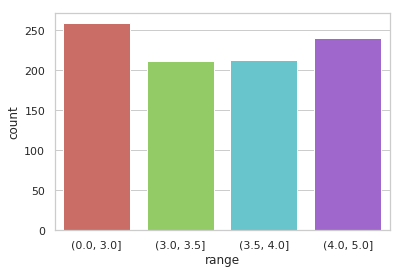

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
    
#draw histogram plot
sns.countplot(x = 'range', data = df_new, palette = 'hls')
plt.show()

In [10]:
#seperate text data
for i in range(len(bins) - 1):
    newdf = df[(bins[i] < df['E_Scale_score']) & (df['E_Scale_score'] <= bins[i+1])]
    texts = newdf['open_ended_1']
    file = os.path.join('labeled-data/', str(i) + '.txt')
    with open(file, 'w') as f:
        for item in texts:
            f.write("%s\n" % item)

In [11]:
# Data Preparation
# ==================================================


# Load data
print("Loading data for CNN classification model--------------------------")
x_text, y = data_helpers.load_data_and_labels(FLAGS.labeled_data_dir)

# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text])
#max_document_length = max([len(x) for x in x_text])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(x_text)))

# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# Split train/test set
dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

del x, y, x_shuffled, y_shuffled
print("Data is successfully loaded!")
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))
print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_dev: ', x_dev.shape)
print('Shape of y_dev: ', y_dev.shape)


Loading data for CNN classification model--------------------------
Following is the data loaded for CNN model:
./labeled-data/0.txt
./labeled-data/1.txt
./labeled-data/2.txt
./labeled-data/3.txt
Following is the labels for supervised learning:
[1, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 1]
Data is successfully loaded!
Vocabulary Size: 2240
Train/Dev split: 740/185
Shape of x_train:  (740, 202)
Shape of y_train:  (740, 4)
Shape of x_dev:  (185, 202)
Shape of y_dev:  (185, 4)


In [ ]:
# Training
# ==================================================

with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())
        if (FLAGS.trained_embedding):
            vocabulary = vocab_processor.vocabulary_
            initW = None
            print("Load embedding file--------------------------------------------------")
            #yes_transfer, no_transfer = 'all', 'labeled'
            #l_embfile = no_transfer + '.' + str(FLAGS.embedding_dim) + '.vec'
            al_embfile = 'all.' + str(FLAGS.embedding_dim) + '.vec'
            if FLAGS.train_vec:
                datafolders = [FLAGS.labeled_data_dir, FLAGS.extra_data_dir]
                if os.path.isfile(FLAGS.embedding_dir + al_embfile):
                    print(al_embfile + 'has already been exist')
                else:
                    data_helpers.train_word_embedding(FLAGS.embedding_dim, "all", df)
                embfile = FLAGS.embedding_dir + al_embfile
            else:
                embfile = "/home/bear/Downloads/glove.42B.300d.txt"
            initW = data_helpers.load_embedding_vectors(vocabulary, embfile, FLAGS.embedding_dim)
            print('embedding file: ' + embfile + ' has been sucessfully loaded!\n')
            sess.run(cnn.W.assign(initW))

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = data_helpers.batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using 